In [1]:

# from google.colab import drive
# drive.mount("/content/drive")

# %cd 'drive/My Drive/bulk_export/'
from helper import *

# Data:
The data contains startups from crunchbase. The data is greatly unbalanced (In addition, alot of startups fail and are never reported on here). Startups have information such as amount raised, whether or not they are still operating, acquired as well as descriptions, categories.

The folder also contains employee and investor data. 

An Accelerator is looking to see if the data provided on crunchbase can be used to create a model for their own application process. The objective is to see if we can determine which startups will fail, which will be acquired/succeed and in what area of expertise they are in. These areas of expertise usually change over time. Ie. recently the verticals "Regtech" and "Digital ID" are becoming more and more popular. Given that there is no existing labels for these startups we can use semi-supervised algoirthms to label them ourselves. The purpose of crunchbase is for investors to get a glimpse at the most up to date startup data. Investors soemtimes have different definitions on trends, therefore this may serve useful in both predicting a companies relevance to an investors definition of a "vertical" as well as potential success. 

# Preprocessing:
Startups need to be companies.In addition we will need to find the acquired companies for companies with status “acquired” for multi-label classification. Also we need to ensure that company size must not be included as this is updated.  We must also create features such as employee degrees etc...

# Prediction: 

We can convert our target to operating and closed. We will use columns that prevent data leaks as we are attempting to look at the startup within a year snapshot of being founded. We want to know if we can predict their status given data collected from one year of operating. We will do labelling on our own at first for the super verticals (ie. regtech) -> we need to identify these from the groups_list we can do clustered semi-supervised ml for this.
We can also use Casual ML to find causal relationships between failure.

What we want to predict is: Acquired, Super Vertical (ie. Regtech).

# Results:
We conclude educaton, location, founded timing, and verticals indeed have a significant effect on the funding and operating status. We use Causalml as well as Randomforest feature importance to visualize this.

# Load, Pre-process and Predict

### Import Data

In [2]:
orgs,dummycolumns=load_data()
events,founders,degrees,orgs=add_features(orgs)

### Convert Founded date to days

In [86]:
# Yanda
# 2019-09-20 -> 365 days
# 2019-09-29 -> 2019,09,29
#import datetime


# orgs["founded_on"]=  pd.to_datetime(orgs["founded_on"], format='%Y-%m-%d')
# orgs["founded_on_year"] = pd.DatetimeIndex(orgs["founded_on"]).year
# orgs["founded_on_month"] = pd.DatetimeIndex(orgs["founded_on"]).month
# orgs["founded_on_day"] = pd.DatetimeIndex(orgs["founded_on"]).day


### One hot Encoding for Categorical

In [90]:
#  # convert categorical columns to one hot encodings
#  # Yanda 
# def convertcategorical_onehot(orgs,column="category_list"):
#   orgs_test = orgs
#   orgs_test = orgs_test[orgs_test[column].notna()]
#   orgs_test= orgs_test.reset_index()
#   full_string = ""
#   for index, row in orgs_test.iterrows():
#     full_string += row[column] +","
#   full_string = full_string[:-1]
#   cl = full_string.split(",")
#   cl = list(set(cl))
#   indexes = list(range(0, len(orgs_test)))
#   df = pd.DataFrame(0,columns=cl,index =indexes) 
#   for index,row in orgs_test.iterrows():
#     category_list = row[column].split(",")
#     for x in category_list:
#       df.at[index, x] = 1
#   orgs_test = pd.concat([orgs_test, df], axis=1)
#   dummycolumns= df.columns
#   return(orgs_test,dummycolumns)

#orgs,dummycolumns=convertcategorical_onehot(orgs.copy(),'category_groups_list')

### Exploration

<AxesSubplot:>

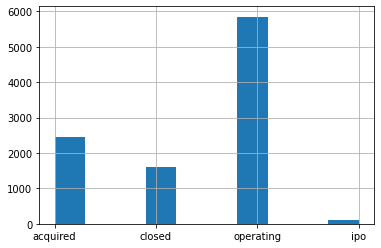

In [9]:
orgs['status'].hist()

In [10]:
# Possible columns
# remove rank, closed_on, num_funding_rounds
orgs_clean = orgs[['type','rank','created_at','updated_at', 'roles',
       'country_code', 'state_code', 'region', 'city', 
       'status', 'short_description', 'category_list', 
       'category_groups_list', 'num_funding_rounds', 'total_funding_usd',
       'total_funding', 'founded_on', 
       'last_funding_on', 'closed_on', 'employee_count',
        'primary_role', 'num_exits']]

# orgs_clean
## drop id-like column
## name, leagal_name, urls, domain, address, postal_code, email, phone, alias123

## other possible drops
## drop rows with closed_on == exact dates, num_exits, rank

## colinearity 
## contry_code, state_code, region, city, total_funding_currency_code (dropped)
## total_funding_usd, total_funding


In [11]:
# count of null values for each column
orgs_clean.isna().sum()

type                        0
rank                        0
created_at                  0
updated_at                  0
roles                       0
country_code             1121
state_code               3697
region                   1121
city                     1121
status                      0
short_description           0
category_list               0
category_groups_list        0
num_funding_rounds       6311
total_funding_usd        6879
total_funding            6879
founded_on                  0
last_funding_on          6311
closed_on                9214
employee_count              0
primary_role                0
num_exits               10000
dtype: int64

### Exploring Funding (convert numbers to categories)

In [94]:
# Ariel

In [12]:
fundings = orgs[[ 'num_funding_rounds', 'total_funding_usd',
       'total_funding',]]
fundings

,num_funding_rounds,total_funding_usd,total_funding
0,3.0,39750000.0,39750000.0
1,6.0,49000000.0,49000000.0
2,1.0,800000.0,800000.0
3,3.0,15000000.0,15000000.0
4,NaN,NaN,NaN
...,...,...,...
9995,NaN,NaN,NaN
9996,2.0,70000000.0,70000000.0
9997,NaN,NaN,NaN
9998,NaN,NaN,NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

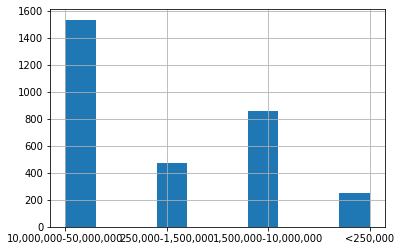

In [14]:
# create a list of our conditions
#l = {'pre-seed': 100000,'seed': 1000000, 'series A':100000-1000000, }
conditions = [
    (fundings['total_funding_usd'] <= 250000),
    (fundings['total_funding_usd'] > 250000) & (fundings['total_funding_usd'] <= 1500000),
    (fundings['total_funding_usd'] > 1500000) & (fundings['total_funding_usd'] <= 10000000),
    (fundings['total_funding_usd'] > 10000000)
    ]

# create a list of the values we want to assign for each condition
values = ['<250,000', '250,000-1,500,000', '1,500,000-10,000,000', '10,000,000-50,000,000']

# create a new column and use np.select to assign values to it using our lists as arguments
fundings['funding_group_usd'] = np.select(conditions, values)

# see all the values for 'funding_group_usd'
fundings['funding_group_usd'].value_counts()
fundings['funding_group_usd'].hist()

### Save profile report

In [23]:
from pandas_profiling import ProfileReport
orgs.drop(['name','type','roles','state_code','index','uuid','address','permalink','cb_url','created_at','rank','updated_at','legal_name','postal_code','domain','homepage_url','num_funding_rounds','total_funding_currency_code','facebook_url','linkedin_url','twitter_url','alias1','alias2','alias3','primary_role','num_exits','logo_url','short_description','total_funding','founded_on','category_list','category_groups_list','last_funding_on','closed_on','employee_count','email','phone'],inplace=True,axis=1)

profiler=orgs.profile_report()
profiler.to_file(output_file="reportcrunchbase.html")

Summarize dataset:   0%|          | 0/71 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Convert target to Binary

In [3]:
orgs=orgs[orgs['status'].isna()==False]
orgs=orgs[orgs['status'].isin(['acquired','closed','operating','ipo'])]

from collections import Counter
Counter(orgs['status'])
orgs['status']= [0 if x =='closed' else 1 for x in orgs['status']]

orgs.drop(['Unnamed: 0'],axis=1,inplace=True)
orgs.reset_index(drop=True,inplace=True)

### Stratified Split

In [180]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(orgs, orgs['status']):
     strat_train_set = orgs.loc[train_index]
     strat_test_set = orgs.loc[test_index]
    
    
data_raised=strat_train_set['total_funding_usd']
data = strat_train_set.copy().drop(['status','total_funding_usd'],axis=1)
data_labels = strat_train_set["status"].copy()
data_cat=data[['country_code', 'region', 'city' ]]

test_raised=strat_test_set['total_funding_usd']
X_test = strat_test_set.drop(['status','total_funding_usd'],axis=1)
X_test[cat_attribs]=X_test[cat_attribs].astype(str)
y_test = strat_test_set["status"].copy()

### Pipeline 

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



print("Starting phase 1 Numerical")
data_num = data[['founded_on_year','founded_on_month','founded_on_day']]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#data_num_tr = num_pipeline.fit_transform(data_num)

print("Starting starting phase 2 Categorical")
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
data[data_cat.columns]=data[data_cat.columns].astype(str)
num_attribs = list(data_num)
cat_attribs = list(data_cat.columns)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
    ],remainder='passthrough')

data_prepared = full_pipeline.fit_transform(data.copy())


Starting phase 1 Numerical
Starting starting phase 2 Categorical


In [182]:

#Get the feature names, taken from: https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api/57534118#57534118
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])
                
    return output_features

cols = get_ct_feature_names(full_pipeline)
data_processed_columns=pd.DataFrame(data_prepared.toarray(), columns=get_ct_feature_names(full_pipeline))


X_test=full_pipeline.transform(X_test)



### Rebalance

In [191]:
print("rebalancing")
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN 
#strategy = {0:5000,1:5000}
sme = SMOTEENN(random_state=42)#strategy = strategy)
data_prepared_balanced, data_labels_balanced = sme.fit_resample(data_prepared.copy(), data_labels)
#data_prepared_balanced, data_labels_balanced = data_prepared.copy(),data_labels#sme.fit_resample(data_prepared.copy(), data_labels)


rebalancing


In [186]:
#former 
data_processed_balanced_columns=pd.DataFrame(data_prepared_balanced.toarray(), columns=get_ct_feature_names(full_pipeline))
Counter(data_labels)

Counter({0: 1276, 1: 6724})

In [50]:
#balanced
Counter(data_labels_balanced)

Counter({0: 6199, 1: 1959})

### Feature Selection

In [72]:
# Random Forest
# Load libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Run Random Forest
rf = RandomForestClassifier(random_state=5, n_estimators=100)
model = rf.fit(data_prepared_balanced,data_labels_balanced)
# Using the model to predict the results based on the test dataset
y_test_pred = model.predict(X_test)
# Calculate the mean squared error of the prediction
accuracy_ratio = accuracy_score(y_test, y_test_pred)
print(accuracy_ratio)


importance = model.feature_importances_
importances_named=pd.DataFrame(rf.feature_importances_)
importances_named.index=data_processed_columns.columns

# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))


from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_],self.feature_indices_
    
k=100
#top_k_feature_indices = indices_of_top_k(forest_reg.feature_importances_, 10)
#Feature selection using top feature selector

data_prepared_top,indices = TopFeatureSelector(rf.feature_importances_, k).fit_transform(data_prepared_balanced)

0.5875


In [249]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    print("Recall")
    print(TP/(TP+FN))
    
    print("Precision")
    print(TP/(TP+FP))
    return(TP, FP, TN, FN)

perf_measure(y_test.reset_index(drop=True),rf.predict(X_test))

0.5814385003701708
Recall
0.6061867935752528
Precision
0.862098138747885


(1019, 163, 156, 662)

### Recall
Of all those operating, we predicted 60% of them accuractely
### Precision
Of those we predicted as operating, 86% are actaully operating

Choose Recall if the idea of false positives is far better than false negatives, in other words, if the occurrence of false negatives is unaccepted/intolerable, that you’d rather get some extra false positives(false alarms) over saving some false negatives, like in our diabetes example.


You’d rather get some healthy people labeled diabetic over leaving a diabetic person labeled healthy.
Choose precision if you want to be more confident of your true positives. for example, Spam emails. You’d rather have some spam emails in your inbox rather than some regular emails in your spam box. So, the email company wants to be extra sure that email Y is spam before they put it in the spam box and you never get to see it.

<AxesSubplot:>

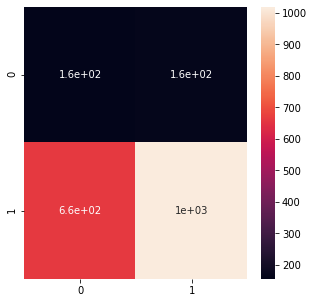

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (5,5))
sn.heatmap(confusion_matrix(y_test.reset_index(drop=True),rf.predict(X_test)), annot=True)


<AxesSubplot:>

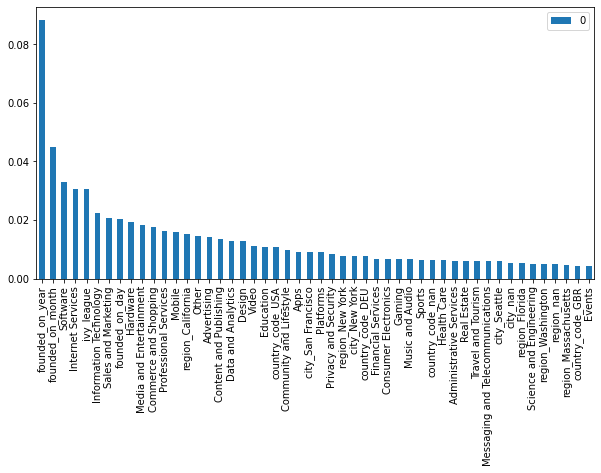

In [77]:
plt.rcParams["figure.figsize"] = (10,5)
importances_named.sort_values(by=0,ascending=False)[0:50].plot.bar()

In [78]:
Counter(y_test_pred)
Counter(y_test)

Counter({1: 1182, 0: 818})

### Accuracy + Recall + Precision + AUROC

We get low test set accuracy, however our CV accuracy is high. We see oversampling and undersampling help increase the accuracy. Let's try to optimize for recall (we don't want to predict good companies by accident). We see however, optimizing for recall does not do much for our test set.

#### Accuracy

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(data_prepared_top, data_labels_balanced)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy')

In [89]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
    
best_model_acc = grid_search.best_estimator_

0.867254667589728 {'max_features': 2, 'n_estimators': 3}
0.8887016925195971 {'max_features': 2, 'n_estimators': 10}
0.9067218069647867 {'max_features': 2, 'n_estimators': 30}
0.8654158012966128 {'max_features': 4, 'n_estimators': 3}
0.8898051294809943 {'max_features': 4, 'n_estimators': 10}
0.9062310700300715 {'max_features': 4, 'n_estimators': 30}
0.8654173337227498 {'max_features': 6, 'n_estimators': 3}
0.8844137388313177 {'max_features': 6, 'n_estimators': 10}
0.9010843267060409 {'max_features': 6, 'n_estimators': 30}
0.87203592728007 {'max_features': 8, 'n_estimators': 3}
0.888581126639696 {'max_features': 8, 'n_estimators': 10}
0.899981881314497 {'max_features': 8, 'n_estimators': 30}
0.8811070336556837 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.8991212437531099 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.8846619918655215 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.902922021143875 {'bootstrap': False, 'max_features': 3, 'n_estim

#### ROC_AUC

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search2 = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='roc_auc',
                           return_train_score=True)
grid_search2.fit(data_prepared_balanced, data_labels_balanced)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='roc_auc')

In [97]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
best_model_roc = grid_search2.best_estimator_

0.867254667589728 {'max_features': 2, 'n_estimators': 3}
0.8887016925195971 {'max_features': 2, 'n_estimators': 10}
0.9067218069647867 {'max_features': 2, 'n_estimators': 30}
0.8654158012966128 {'max_features': 4, 'n_estimators': 3}
0.8898051294809943 {'max_features': 4, 'n_estimators': 10}
0.9062310700300715 {'max_features': 4, 'n_estimators': 30}
0.8654173337227498 {'max_features': 6, 'n_estimators': 3}
0.8844137388313177 {'max_features': 6, 'n_estimators': 10}
0.9010843267060409 {'max_features': 6, 'n_estimators': 30}
0.87203592728007 {'max_features': 8, 'n_estimators': 3}
0.888581126639696 {'max_features': 8, 'n_estimators': 10}
0.899981881314497 {'max_features': 8, 'n_estimators': 30}
0.8811070336556837 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.8991212437531099 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.8846619918655215 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.902922021143875 {'bootstrap': False, 'max_features': 3, 'n_estim

#### Recall

In [250]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search3 = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='recall',
                           return_train_score=True)
grid_search3.fit(data_prepared_balanced, data_labels_balanced)


0.7999554913990137 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 3}
0.8117235053530614 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10}
0.849727835919644 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 30}
0.799097197161073 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 3}
0.8111101587874414 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10}
0.8494812342114761 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 30}
0.8145395765668232 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 3}
0.8304777156261277 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 10}
0.8509557319860459 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 30}
0.8123336942138819 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 3}
0.8292510224948874 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_

0.7999554913990137 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 3}
0.8117235053530614 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 10}
0.849727835919644 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 30}
0.799097197161073 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 3}
0.8111101587874414 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 10}
0.8494812342114761 {'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 30}
0.8145395765668232 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 3}
0.8304777156261277 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 10}
0.8509557319860459 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 30}
0.8123336942138819 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 3}
0.8292510224948874 {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_

<AxesSubplot:>

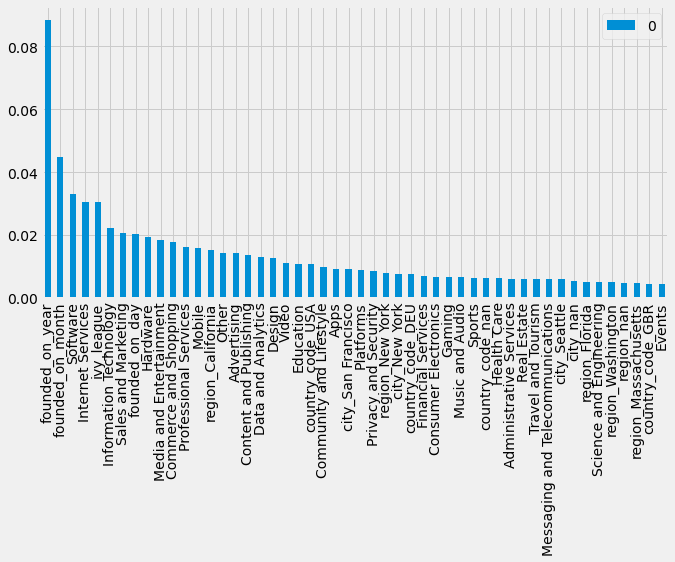

In [255]:

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)
best_model_recall = grid_search3.best_estimator_

best_model_recall.fit(data_prepared_balanced, data_labels_balanced)
y_test_pred = best_model_recall.predict(X_test)
# Calculate the mean squared error of the prediction
accuracy_ratio = accuracy_score(y_test, y_test_pred)
print(accuracy_ratio)
from sklearn.metrics import recall_score
print(recall_score(y_test,y_test_pred))
print(roc_auc_score(y_test, best_model_recall.predict_proba(X_test)[:, 1]))

importance = best_model_recall.feature_importances_
importances_named=pd.DataFrame(rf.feature_importances_)
importances_named.index=data_processed_columns.columns

importances_named.sort_values(by=0,ascending=False)[0:50].plot.bar()

In [254]:
best_model_acc.fit(data_prepared_balanced, data_labels_balanced)
y_test_pred = best_model_acc.predict(X_test)
# Calculate the mean squared error of the prediction
accuracy_ratio = accuracy_score(y_test, y_test_pred)
print(accuracy_ratio)
print(recall_score(y_test,y_test_pred))
importance = best_model_acc.feature_importances_
importances_named=pd.DataFrame(rf.feature_importances_)
importances_named.index=data_processed_columns.columns

0.5725
0.578227245687091


In [95]:
roc_auc_score(y_test, best_model_acc.predict_proba(X_test)[:, 1])

0.5642120397807693

<AxesSubplot:>

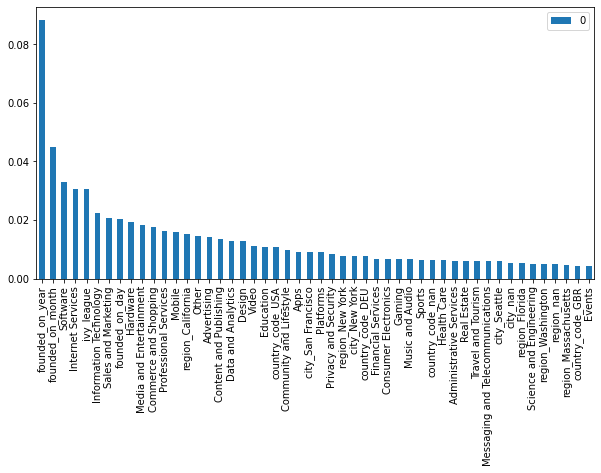

In [94]:
plt.rcParams["figure.figsize"] = (10,5)
importances_named.sort_values(by=0,ascending=False)[0:50].plot.bar()

In [98]:
best_model_roc.fit(data_prepared_balanced, data_labels_balanced)
y_test_pred = best_model_roc.predict(X_test)
# Calculate the mean squared error of the prediction
accuracy_ratio = accuracy_score(y_test, y_test_pred)
print(accuracy_ratio)
importance = best_model_roc.feature_importances_
importances_named=pd.DataFrame(rf.feature_importances_)
importances_named.index=data_processed_columns.columns


0.5725


In [99]:
roc_auc_score(y_test, best_model_roc.predict_proba(X_test)[:, 1])

0.5642120397807693

<AxesSubplot:>

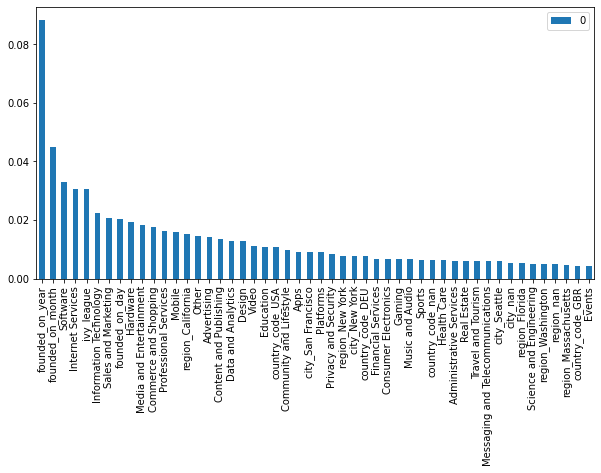

In [100]:
plt.rcParams["figure.figsize"] = (10,5)
importances_named.sort_values(by=0,ascending=False)[0:50].plot.bar()

### XGBoost 

In [101]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 1, 1.5],
        'max_depth': [3, 4],
        'n_estimators': [3, 10, 30],
        }

from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=42,silent=True)
grid_search = GridSearchCV(xgb, params, cv=10,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(data_prepared_balanced, data_labels_balanced)

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[00:48:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:48:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:48:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:48:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:48:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

[00:49:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:49:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

### CasualML

In [203]:
treatment = ['treatment' if x == 1 else 'control' for x in data_processed_columns['ivy_league']]
top_balanced=data_processed_columns[data_processed_columns.columns[indices]]

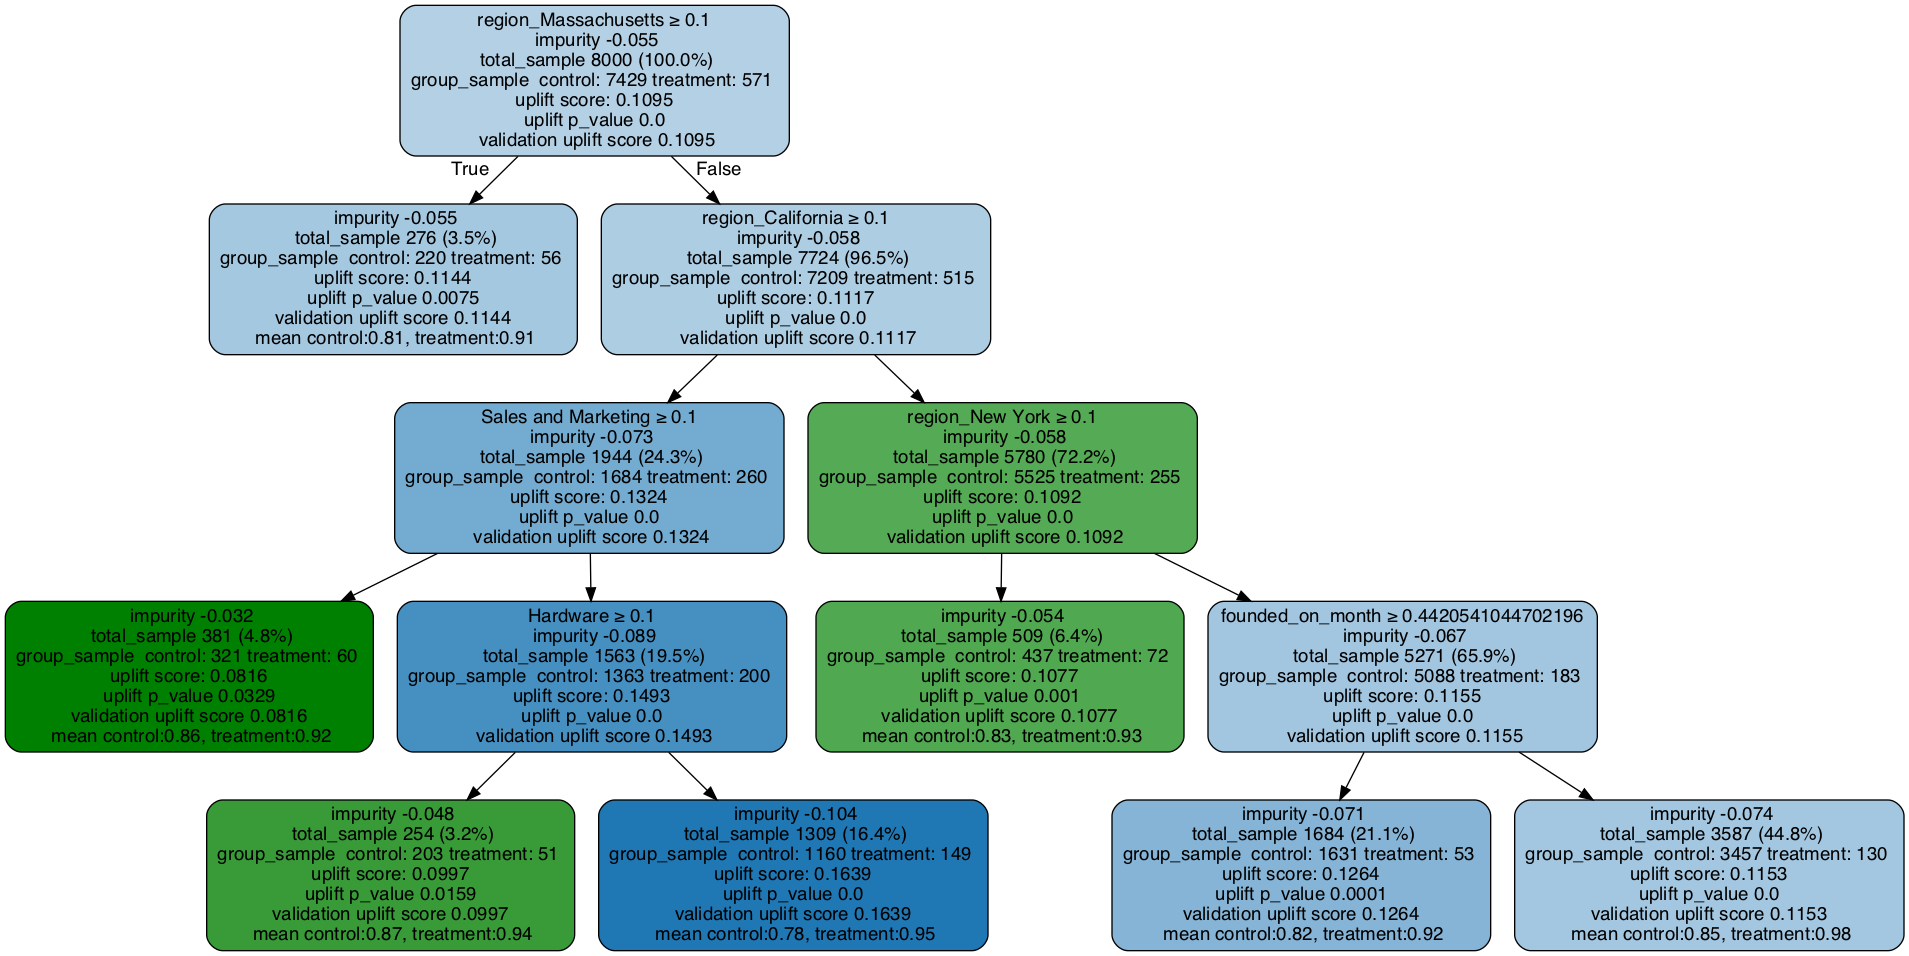

In [206]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
y, X, treatment = data_labels.reset_index(drop=True).values,top_balanced.drop(['ivy_league'],axis=1).values,np.array(treatment)

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X,
                 treatment=treatment,
                 y=y)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, list(top_balanced.columns))
Image(graph.create_png())

In [208]:
result = uplift_tree_string(uplift_model.fitted_uplift_tree, list(top_balanced.columns))
result

region_Massachusetts >= 0.1?
yes -> {'control': 0.809091, 'treatment': 0.910714}
no  -> region_California >= 0.1?
		yes -> Sales and Marketing >= 0.1?
				yes -> {'control': 0.862928, 'treatment': 0.916667}
				no  -> Hardware >= 0.1?
						yes -> {'control': 0.866995, 'treatment': 0.941176}
						no  -> {'control': 0.780172, 'treatment': 0.946309}
		no  -> region_New York >= 0.1?
				yes -> {'control': 0.832952, 'treatment': 0.930556}
				no  -> founded_on_month >= 0.4420541044702196?
						yes -> {'control': 0.818516, 'treatment': 0.924528}
						no  -> {'control': 0.85363, 'treatment': 0.976923}


In [210]:
from causalml.inference.meta import BaseXClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
#Propensity Model
prop_model = LGBMClassifier(colsample_bytree=0.8, subsample = 0.8, n_estimators=300)
print(cross_val_score(prop_model, X, treatment, cv=5, scoring='roc_auc').mean())
#model achieves AUC of 0.57, which makes it useful in evaluating the test outcome

#Fitting the model
prop_model.fit(X, treatment)

#Getting propensity scores
prop_scores = prop_model.predict_proba(X)


learner_x = BaseXClassifier(LGBMClassifier(colsample_bytree=0.8, num_leaves=50, n_estimators=200),
                            control_effect_learner=LinearRegression(),
                            treatment_effect_learner=LinearRegression(), control_name='control')

#Getting the average treatment effect with upper and lower bounds
ate_x, ate_x_lb, ate_x_ub = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p = prop_scores[:, 1])
print(ate_x, ate_x_lb, ate_x_ub)

0.7289597253029808
[5.84357802e+09] [3.06631704e+09] [8.62083901e+09]


In [221]:
data_raised_y= [0 if str(x) == "nan" else x for x in data_raised]

y=np.array(data_raised_y)
treatment=data_processed_columns['ivy_league'].values


In [223]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseSRegressor
from causalml.inference.meta import BaseRRegressor
from causalml.inference.meta import BaseTRegressor
from causalml.inference.meta import BaseXRegressor

from lightgbm import LGBMRegressor



lr = LRSRegressor()
telr, lblr, ublr = lr.estimate_ate(X,treatment, y)
lr_tau = lr.fit_predict(X, treatment, y)

print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(telr[0], lblr[0], ublr[0]))
xg = XGBTRegressor(random_state=42)
texg, lbxg, ubxg = xg.estimate_ate(X, treatment, y)
xg_tau = xg.fit_predict(X, treatment, y)


print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(texg[0], lbxg[0], ubxg[0]))


base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name=0)
slearner.estimate_ate(X, treatment, y)
slearner_tau = slearner.fit_predict(X, treatment, y)
s_ate = slearner.estimate_ate(X, treatment, y)[0]
s_ite = slearner.fit_predict(X, treatment, y)

print('Average Treatment Effect SRegressor: {:.2f}'.format(s_ate))

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)
      
print('Average Treatment Effect TRegressor: {:.2f}'.format(t_ate))




Average Treatment Effect (Linear Regression): 53238339.78 (38338897.87, 68137781.69)
Average Treatment Effect (XGBoost): 57215443.17 (52305671.35, 62125214.99)
Average Treatment Effect SRegressor: 48314616.08
Average Treatment Effect TRegressor: 49976796.72


We also see that the average treatment effect is positive for funding when going to an ivy league

In [239]:
lrshaps[1].shape

(8000, 99)

2. Shap: 
Being older in general is worse for startups in terms of funding. Commmerce and shopping seem to be beneficial, as well as being based in San francisco, California. Being in Data and Analytics and IT are favorable. Being from Washington has a negative effect apparently.
3. Shap:
Being founded later in the year seems to be worse for funding. Software and commerce are favorable for funding. MMedia and Entertainment is not. Data and Analytics and Sanfrancisco are favorable.
4. Shap:
Commerce and Shopping are the most important. Being founded early in the year seems favorable. Community life style, mobile, software, IT, being from San Fran is viewed favorably, but internet services and media and entertainment are not.

Interestingly being from LA is a mixed bag in terms of funding, so is hardware

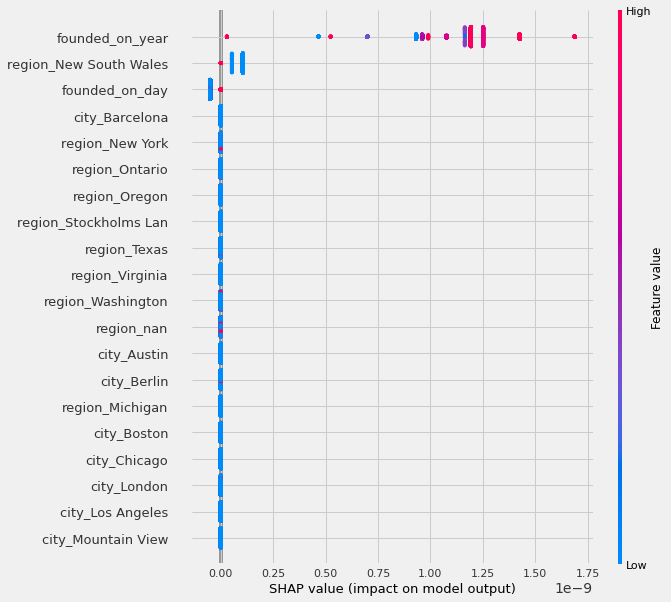

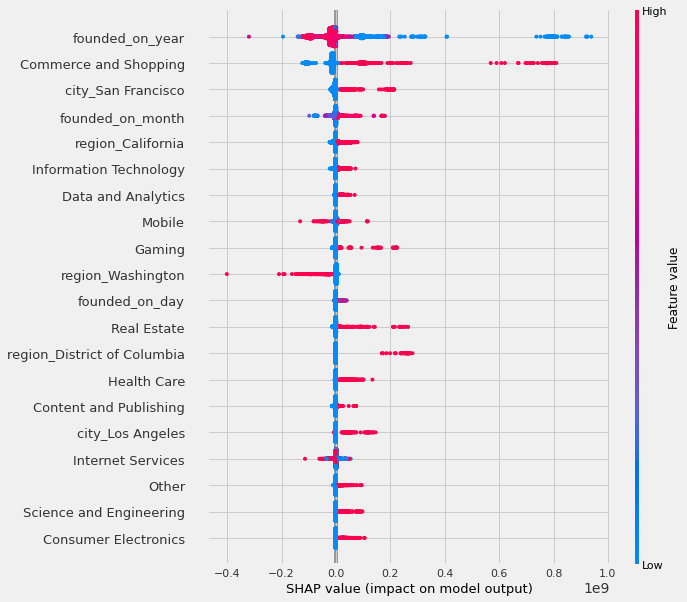

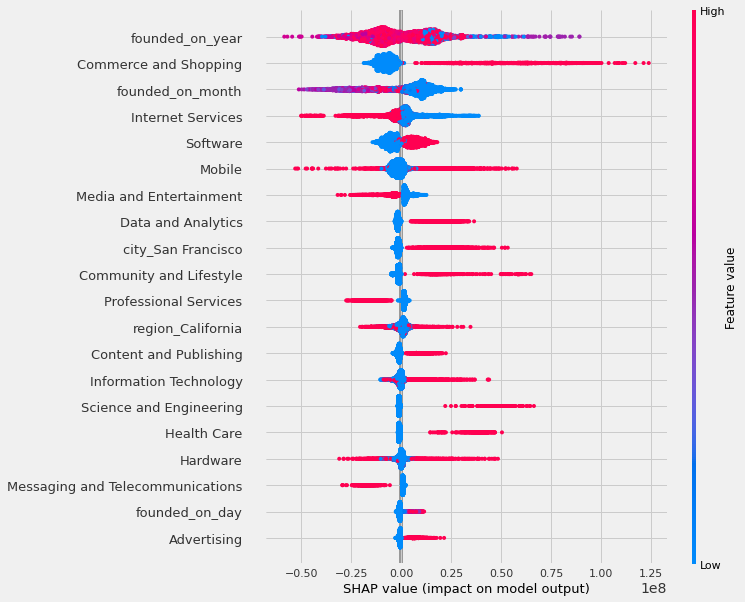

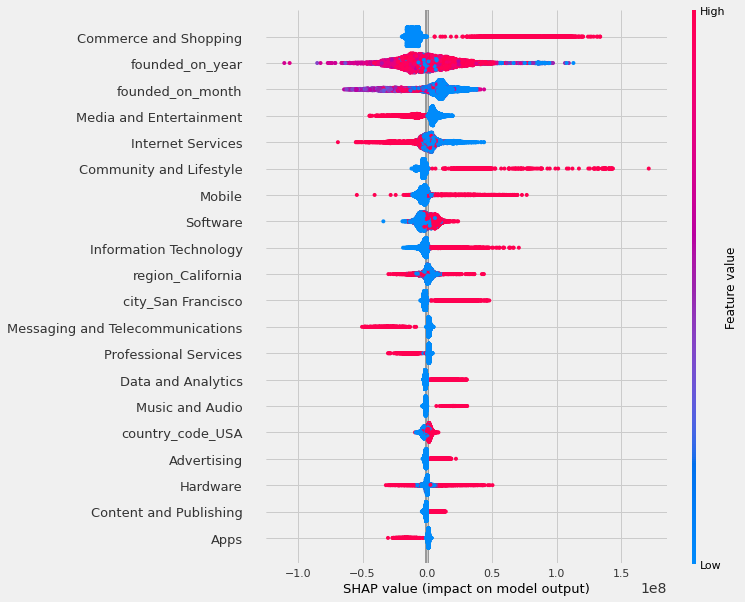

In [243]:
import shap
lrshaps=lr.get_shap_values(X=X, tau=lr_tau, features=top_balanced.columns)
xgshaps=xg.get_shap_values(X=X, tau=xg_tau, features=top_balanced.columns)
slearnershaps=slearner.get_shap_values(X=X, tau=slearner_tau, features=top_balanced.columns)
t_learnershaps=slearner.get_shap_values(X=X, tau=t_ite, features=top_balanced.columns)

shap.summary_plot(lrshaps[1], top_balanced.drop('ivy_league',axis=1))
shap.summary_plot(xgshaps[1],  top_balanced.drop('ivy_league',axis=1))
shap.summary_plot(slearnershaps[1],  top_balanced.drop('ivy_league',axis=1))
shap.summary_plot(t_learnershaps[1],  top_balanced.drop('ivy_league',axis=1))


Take a look at the ivy league failure and success rates. 94% of startups are still operating for ivy league founders

In [172]:
len(orgs[(orgs['ivy_league']==1)&(orgs['status']==1)])/len(orgs[orgs['ivy_league']==1])

0.9436038514442916

In [176]:
len(orgs[(orgs['ivy_league']==1)&(orgs['status']==0)])/len(orgs[orgs['ivy_league']==1])

0.05639614855570839

Take a look at non ivy league failure and success rates. 83% of startups are still operating for ivy league founders

In [103]:
len(orgs[(orgs['ivy_league']==0)&(orgs['status']==1)])/len(orgs[orgs['ivy_league']==0])

0.832416693626658

### Causal Inference Conclusion

Being from San Fran and ivy league schools is definitely beneficial to operating status and funding status. Certain verticals such as data analytics (cough cough MMA), IT and commerce are indicators of success. In addition being founded at the start of the year seems to be important.

### Report on Ivy League and Status 

In [169]:
orgs[['ivy_league','status']].profile_report()

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [104]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor
from causalml.dataset import synthetic_data

from lightgbm import LGBMRegressor
y, X, treatment = data_labels_balanced.reset_index(drop=True),np.array(top_balanced.drop(['ivy_league'],axis=1)),np.array(treatment)

lr = LRSRegressor()
telr, lblr, ublr = lr.estimate_ate(X,treatment, y)
lr_tau = lr.fit_predict(X, treatment, y)

print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(telr[0], lblr[0], ublr[0]))
xg = XGBTRegressor(random_state=42)
texg, lbxg, ubxg = xg.estimate_ate(X, treatment, y)
xg_tau = xg.fit_predict(X, treatment, y)


print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(texg[0], lbxg[0], ubxg[0]))


# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


NameError: name 'top_balanced' is not defined

In [ ]:
from causalml.inference.meta import BaseSRegressor
base_algo = LGBMRegressor()
slearner = BaseSRegressor(base_algo, control_name=0)
slearner.estimate_ate(X, treatment, data_labels_balanced.reset_index(drop=True))
slearner_tau = slearner.fit_predict(X, treatment, data_labels_balanced.reset_index(drop=True))

In [ ]:
import matplotlib.pyplot as plt

lr.plot_importance(X=X, 
                        tau=lr_tau,
                        normalize=True, 
                        method='auto', 
                        features=top_balanced.drop(['ivy_league'],axis=1).columns)
lr.plot_importance(X=X, 
                         tau=lr_tau, 
                         method='permutation', 
                         features=top_balanced.drop(['ivy_league'],axis=1).columns, 
                         random_state=42)
xg.plot_importance(X=X, 
                        tau=xg_tau,
                        normalize=True, 
                        method='auto', 
                        features=top_balanced.drop(['ivy_league'],axis=1).columns)

xg.plot_importance(X=X, 
                        tau=xg_tau,
                        normalize=True, 
                        method='permutation', 
                        features=top_balanced.drop(['ivy_league'],axis=1).columns)

slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=top_balanced.drop(['ivy_league'],axis=1).columns)

slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='permutation', 
                         features=top_balanced.drop(['ivy_league'],axis=1).columns)

### Semi-supervised Clustering ML


We want to predict from a small labelled dataset, broad verticals such as "Regtech" etc...

In [181]:
orgs2 = pd.read_csv("organizations.csv")

In [182]:
orgsdesc = pd.read_csv("organization_descriptions.csv")

In [183]:
orgs2=pd.merge(orgs2,orgsdesc[['uuid','description']],left_on="uuid",right_on="uuid")

In [259]:
holt=pd.read_excel("labelled_manually.xlsx")

In [260]:
holtcomps = holt[holt['Startup/Person Name'].isin(orgs2['name'])]

In [261]:
orgsnew=pd.read_csv("filtered_orgs.csv")

In [262]:
orgsholt=orgsnew[orgsnew['name'].isin(holtcomps['Startup/Person Name'])]

In [263]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
clustering = AgglomerativeClustering().fit(orgsholt[dummycolumns])

In [264]:
orgsholt=pd.merge(orgsholt,holtcomps[['Startup/Person Name','Question 1: What market are you addressing?']],left_on="name",right_on="Startup/Person Name")

In [265]:
orgsholt=orgsholt[orgsholt['Question 1: What market are you addressing?'].isna()==False]
orgsholt.reset_index(drop=True,inplace=True)

In [266]:
orgsholt['Question 1: What market are you addressing?']

0               Blockchain / Cryptocurrency
1               Blockchain / Cryptocurrency
2                   Payments / Transactions
3                   Payments / Transactions
4                             CyberSecurity
                       ...                 
114                                 Lending
115    Investment Banking / Capital Markets
116                                 Lending
117             Institutional / B2B Fintech
118                 Payments / Transactions
Name: Question 1: What market are you addressing?, Length: 119, dtype: object

In [257]:

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

k =50
kmeans = KMeans(n_clusters=k)
sample = orgsholt[dummycolumns][0:50]
sample_labels = orgsholt['Question 1: What market are you addressing?'][0:50]
X_digits_dist = kmeans.fit_transform(sample)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = sample.values[representative_digit_idx]

log_reg = LogisticRegression()
log_reg.fit(X_representative_digits, sample_labels)
log_reg.score(orgsholt[dummycolumns][50:len(orgsholt)],orgsholt['Question 1: What market are you addressing?'][50:len(orgsholt)])

0.13043478260869565

In [ ]:
# accuracy too low